In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/chuyendecntt/input

In [ ]:
#Đọc tập tin dicom
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import cv2
from tensorflow import keras
import tensorflow as tf

In [ ]:
# Read and examine metadata
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/chuyendecntt/input/covid19-ct-scans/metadata.csv')
data.sample(5)
data.head(3)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array)) #this data needs to rotate 90 degrees
    return(array)

In [ ]:
# Read sample
sample_ct = read_nii(data.loc[0,'ct_scan'])


In [ ]:
print (sample_ct.shape)


(512, 512, 301)


In [ ]:
#Check HU transform is done or not Kiểm tra quá trình biến đổi HU đã thực hiện hay chưa

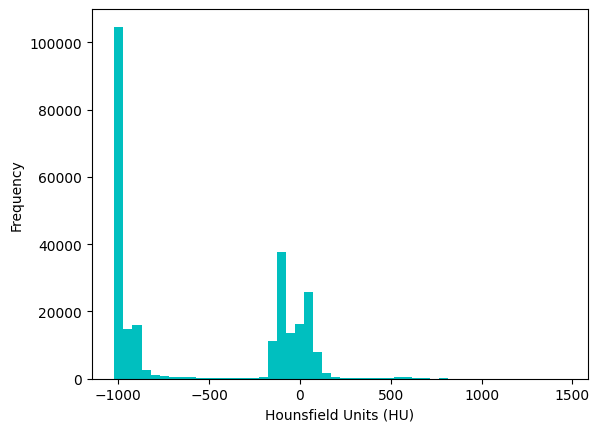

In [ ]:
imgs_to_process = sample_ct[...,1]

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#No need to transform
CT = []
Mask = []
img_size = 128

for case in range(len(data)): #Concat all cases to list
    ct = read_nii(data['ct_scan'][case])
    mask = read_nii(data['infection_mask'][case])

    for imgsize in range(ct.shape[2]): #Convert pixals to 1-d array

        ct_img = cv2.resize(ct[..., imgsize], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        mask_img = cv2.resize(mask[..., imgsize],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        CT.append(ct_img[..., np.newaxis])
        Mask.append(mask_img[..., np.newaxis])

In [ ]:
CT = np.array(CT)
Mask = np.array(Mask)

In [ ]:
#I choose using CT directly¶
#Chuẩn hóa giá trị pixel của dữ liệu CT vào khoảng [0, 1] trước khi huấn luyện mô hình.
mins = CT.min(axis=(1,2,3), keepdims=True)
maxs = CT.max(axis=(1,2,3), keepdims=True)
norm_data = (CT-mins)/(maxs-mins)

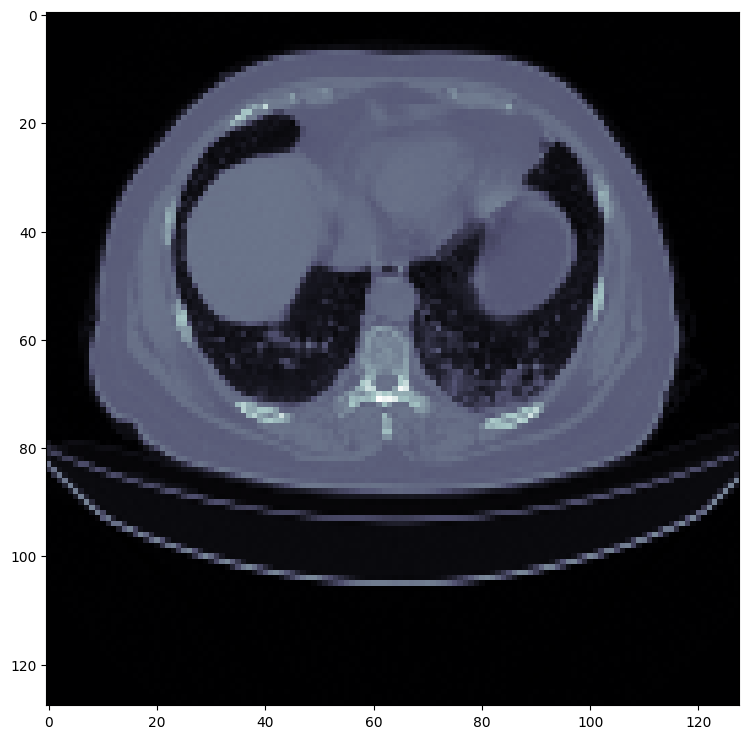

In [ ]:
plt.figure(figsize = (9,9))

plt.imshow(norm_data[100][...,0], cmap = 'bone')

In [ ]:
#Split into training and validation groups
from sklearn.model_selection import train_test_split
CT_train, CT_test, Mask_train, Mask_test = train_test_split(norm_data, Mask, test_size = 0.2)

In [ ]:
#Build Attention Unet
class attention_unet():
  def __init__(self,img_rows=128,img_cols=128):
    self.img_rows=img_rows
    self.img_cols=img_cols
    self.img_shape=(self.img_rows,self.img_cols,1)
    self.df=64
    self.uf=64

  def build_unet(self):
    def conv2d(layer_input,filters,dropout_rate=0,bn=False):
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(layer_input)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)

      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(d)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)

      if dropout_rate:
        d=layers.Dropout(dropout_rate)(d)

      return d

    def deconv2d(layer_input,filters,bn=False):
      u=layers.UpSampling2D((2,2))(layer_input)
      u=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(u)
      if bn:
        u=layers.BatchNormalization()(u)
      u=layers.Activation('relu')(u)

      return u

    def attention_block(F_g,F_l,F_int,bn=False):
      g=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_g)
      if bn:
        g=layers.BatchNormalization()(g)
      x=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_l)
      if bn:
        x=layers.BatchNormalization()(x)
#       print(g.shape)
#       print(x.shape)
      psi=layers.Add()([g,x])
      psi=layers.Activation('relu')(psi)

      psi=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi)

      if bn:
        psi=layers.BatchNormalization()(psi)
      psi=layers.Activation('sigmoid')(psi)

      return layers.Multiply()([F_l,psi])

    inputs=layers.Input(shape=self.img_shape)

    conv1=conv2d(inputs,self.df)
    pool1=layers.MaxPooling2D((2,2))(conv1)

    conv2=conv2d(pool1,self.df*2,bn=True)
    pool2=layers.MaxPooling2D((2,2))(conv2)

    conv3=conv2d(pool2,self.df*4,bn=True)
    pool3=layers.MaxPooling2D((2,2))(conv3)

    conv4=conv2d(pool3,self.df*8,dropout_rate=0.5,bn=True)
    pool4=layers.MaxPooling2D((2,2))(conv4)

    conv5=conv2d(pool4,self.df*16,dropout_rate=0.5,bn=True)

    up6=deconv2d(conv5,self.uf*8,bn=True)
    conv6=attention_block(up6,conv4,self.uf*8,bn=True)
    up6=layers.Concatenate()([up6,conv6])
    conv6=conv2d(up6,self.uf*8)

    up7=deconv2d(conv6,self.uf*4,bn=True)
    conv7=attention_block(up7,conv3,self.uf*4,bn=True)
    up7=layers.Concatenate()([up7,conv7])
    conv7=conv2d(up7,self.uf*4)

    up8=deconv2d(conv7,self.uf*2,bn=True)
    conv8=attention_block(up8,conv2,self.uf*2,bn=True)
    up8=layers.Concatenate()([up8,conv8])
    conv8=conv2d(up8,self.uf*2)

    up9=deconv2d(conv8,self.uf,bn=True)
    conv9=attention_block(up9,conv1,self.uf,bn=True)
    up9=layers.Concatenate()([up9,conv9])
    conv9=conv2d(up9,self.uf)

    outputs=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(conv9)

    model=Model(inputs=inputs,outputs=outputs)

    return model


# In[29]:


from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model.model", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [ ]:
#Define BatchNormalization
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import keras.layers as layers
from keras.models import Model



# batchnormalization
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
# block
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x
# residual_block
def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [ ]:
#Loss functions
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) +
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [ ]:
from keras.optimizers import Adam

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

In [ ]:
#Implement of "Boundary loss for highly unbalanced segmentation"
from scipy.ndimage import distance_transform_edt as distance


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    y_true_numpy = y_true
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.numpy_function(func=calc_dist_map_batch,
                                        inp=[y_true],
                                        Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

In [ ]:
from keras.callbacks import ModelCheckpoint, Callback


class AlphaScheduler(Callback):
  def init(self, alpha, update_fn):
    self.alpha = alpha
    self.update_fn = update_fn
  def on_epoch_end(self, epoch, logs=None):
    updated_alpha = self.update_fn(K.get_value(self.alpha))

alpha = K.variable(1, dtype='float32')

def update_alpha(value):
  return np.clip(value - 0.01, 0.01, 1)

In [ ]:
#We should considering both boundary loss and weighted binary cross entropy dice loss
def gl_sl_wrapper(alpha):
    def gl_sl(y_true, y_pred):
        return alpha* weighted_bce_dice_loss(y_true, y_pred) +  (1-alpha)* surface_loss_keras(y_true, y_pred)
    return gl_sl

In [ ]:
def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred >= 0.5, tf.bool)
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(y_true, y_pred), tf.float32))
    return true_positives / (tf.reduce_sum(tf.cast(y_true, tf.float32)) + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred >= 0.5, tf.bool)
    true_negatives = tf.reduce_sum(tf.cast(tf.logical_and(~y_true, ~y_pred), tf.float32))
    return true_negatives / (tf.reduce_sum(tf.cast(~y_true, tf.float32)) + tf.keras.backend.epsilon())

In [ ]:
#Set Training Check Point
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights_best.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef",
                      mode="max",
                      patience=30) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
#Compile mode
Net=attention_unet()
unet=Net.build_unet()

unet.compile(loss=gl_sl_wrapper(alpha),
             optimizer=Adam(1e-4),
             metrics=[dice_coef, 'binary_accuracy',
                     sensitivity, specificity])

unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['activation[0][0]']          
                                                                                              

In [ ]:
#Start Training
# Bắt đầu đếm thời gian huấn luyện
import datetime
start = datetime.datetime.now()
history = unet.fit(CT_train, Mask_train, epochs = 100, validation_data = (CT_test, Mask_test),verbose=1,shuffle=True, callbacks=[checkpoint])
# Kết thúc đếm thời gian huấn luyện
end = datetime.datetime.now()
print ('* total training time:', str(end-start))

Epoch 1/100


<ipython-input-26-1a2f3462d4db>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  posmask = seg.astype(np.bool)


88/88 [==============================] - ETA: 0s - loss: 0.8595 - dice_coef: 0.1509 - binary_accuracy: 0.9792 - sensitivity: 0.1284 - specificity: 0.9888
Epoch 1: val_dice_coef improved from -inf to 0.00662, saving model to model_weights.best.hdf5
88/88 [==============================] - 113s 754ms/step - loss: 0.8595 - dice_coef: 0.1509 - binary_accuracy: 0.9792 - sensitivity: 0.1284 - specificity: 0.9888 - val_loss: 1.0771 - val_dice_coef: 0.0066 - val_binary_accuracy: 0.9904 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.3897 - dice_coef: 0.5062 - binary_accuracy: 0.9922 - sensitivity: 0.6103 - specificity: 0.9979
Epoch 2: val_dice_coef improved from 0.00662 to 0.01286, saving model to model_weights.best.hdf5
88/88 [==============================] - 68s 772ms/step - loss: 0.3897 - dice_coef: 0.5062 - binary_accuracy: 0.9922 - sensitivity: 0.6103 - specificity: 0.9979 - val_loss: 1.0877 - val_dice_coef: 0

In [ ]:
unet.load_weights(weight_path)
unet.save('model_unet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


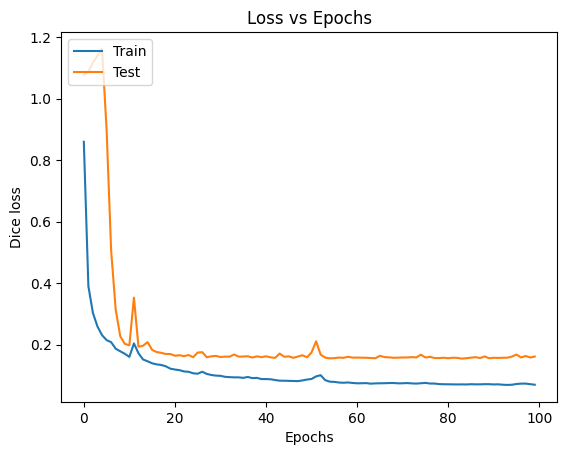

In [ ]:
#Plot loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice loss')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

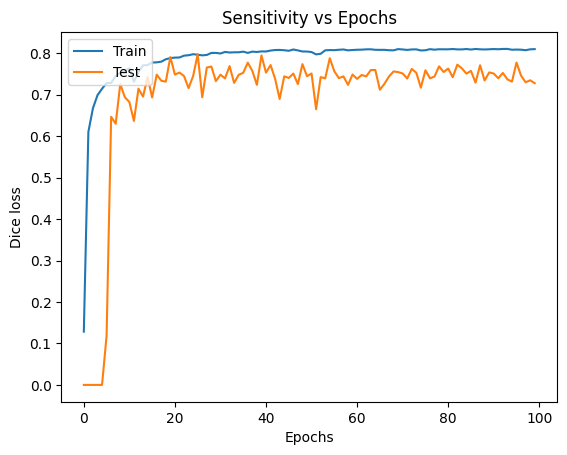

In [ ]:
#Plot sensitivity history
plt.plot(history.history['sensitivity'])
plt.plot(history.history['val_sensitivity'])
plt.title('Sensitivity vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice loss')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

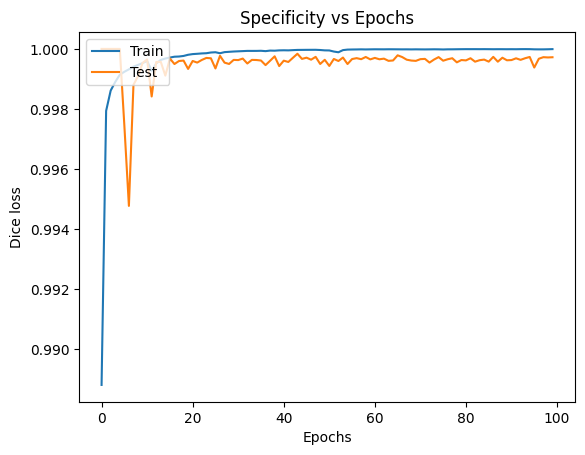

In [ ]:
#Plot Specificity history
plt.plot(history.history['specificity'])
plt.plot(history.history['val_specificity'])
plt.title('Specificity vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice loss')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

22/22 [==============================] - 3s 164ms/step


Text(0.5, 1.0, 'predicted infection mask')

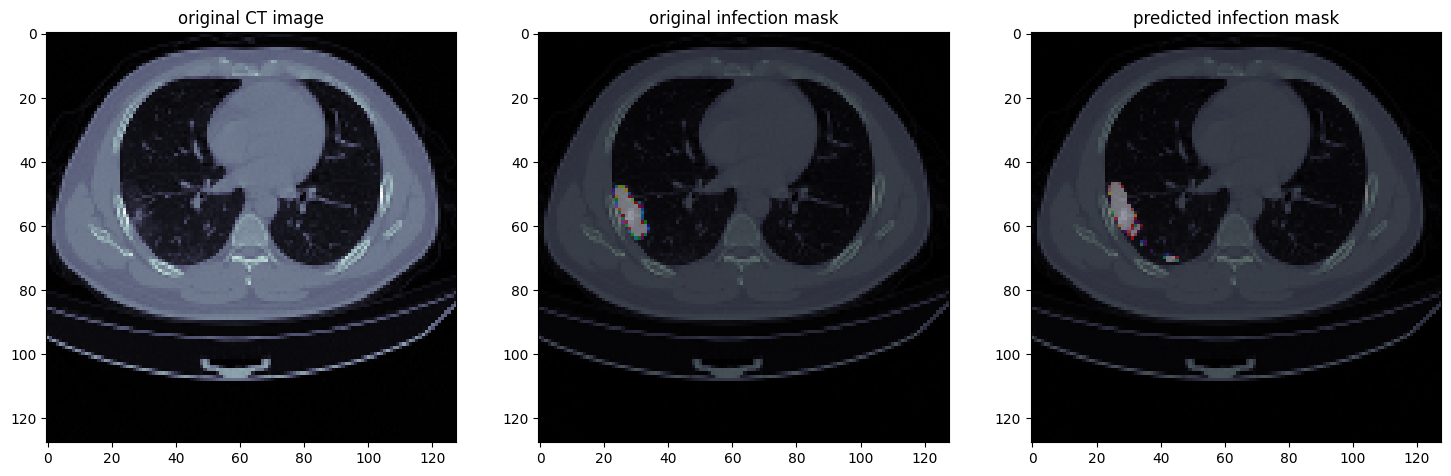

In [ ]:
#Run the test data
predicted = unet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[140][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[140][...,0], cmap = 'bone')
plt.imshow(Mask_test[140][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[140][...,0], cmap = 'bone')
plt.imshow(predicted[140][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

In [ ]:
# from IPython.display import FileLink
# FileLink(r'model_weights.best.hdf5')

/content/drive/MyDrive/Colab Notebooks/chuyendecntt/input/model_weights.best.hdf5

In [ ]:
# from IPython.display import FileLink
# FileLink(r'unet1.h5')

/content/drive/MyDrive/Colab Notebooks/chuyendecntt/input/unet1.h5

In [ ]:
# from keras.models import load_model
# from keras.preprocessing import image
# import numpy as np
# import matplotlib.pyplot as plt

# # Load mô hình phát hiện COVID-19
# densenet_model = load_model('/content/drive/MyDrive/Colab Notebooks/CDCNTT/InceptionV3_xam.h5')

# # Load mô hình UNet với compile=False
# unet_model = load_model('/content/drive/MyDrive/Colab Notebooks/chuyendecntt/input/model_unet.h5', compile=False)

# # Đường dẫn của hình ảnh dương tính COVID-19
# path = '/content/drive/MyDrive/Colab Notebooks/CDCNTT/TEST/COVID/Covid (1096).png'

# # Chuẩn bị dữ liệu cho mô hình dự đoán COVID-19
# img = image.load_img(path, grayscale=True, target_size=(128, 128))  # Điều chỉnh kích thước ảnh đầu vào thành (128, 128)
# show_img = image.load_img(path, grayscale=True, target_size=(200, 200))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x /= 255

# # Dự đoán COVID-19
# prediction = densenet_model.predict(x)
# if prediction[0][0] > prediction[0][1]:
#     print('Prediction: COVID-19')

#     # Phân vùng ảnh COVID-19 bằng mô hình UNet
#     mask = unet_model.predict(x)

#     # Hiển thị kết quả phân vùng
#     plt.subplot(1, 2, 1)
#     plt.imshow(show_img)
#     plt.title('Original Image')

#     plt.subplot(1, 2, 2)
#     plt.imshow(mask[0][:, :, 0], cmap='gray')
#     plt.title('Segmentation Mask')

#     plt.show()

# else:
#     print('Prediction: Non COVID-19')


1/1 [==============================] - 2s 2s/step
Prediction: Non COVID-19


1/1 [==============================] - 4s 4s/step
Prediction: COVID-19 (Probability: 97.76%)
1/1 [==============================] - 2s 2s/step


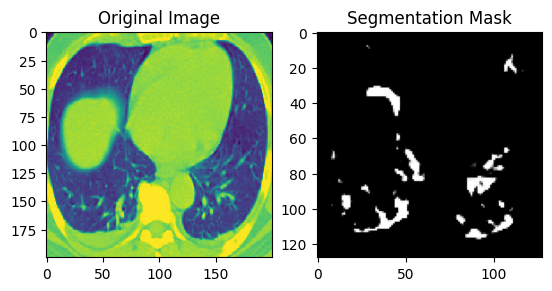

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load mô hình phát hiện COVID-19
densenet_model = load_model('/content/drive/MyDrive/Colab Notebooks/CDCNTT/DenseNet121_L1_xam.h5')

# Load mô hình UNet với compile=False
unet_model = load_model('/content/drive/MyDrive/Colab Notebooks/chuyendecntt/input/model_unet.h5', compile=False)

# Đường dẫn của hình test
path = '/content/drive/MyDrive/Colab Notebooks/CDCNTT/TEST/COVID/Covid (1125).png'

# Chuẩn bị dữ liệu cho mô hình dự đoán COVID-19
img = image.load_img(path, grayscale=True, target_size=(128, 128))  # Điều chỉnh kích thước ảnh đầu vào thành (128, 128)
show_img = image.load_img(path, grayscale=True, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255

# Dự đoán COVID-19
prediction = densenet_model.predict(x)
covid_probability = prediction[0][0] * 100
non_covid_probability = prediction[0][1] * 100

if prediction[0][0] > prediction[0][1]:
    print(f'Prediction: COVID-19 (Probability: {covid_probability:.2f}%)')

    # Phân vùng ảnh COVID-19 bằng mô hình UNet
    mask = unet_model.predict(x)

    # Hiển thị kết quả phân vùng
    plt.subplot(1, 2, 1)
    plt.imshow(show_img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask[0][:, :, 0], cmap='gray')
    plt.title('Segmentation Mask')

    plt.show()

else:
    print(f'Prediction: Non COVID-19 (Probability: {non_covid_probability:.2f}%)')

1/1 [==============================] - 4s 4s/step
Prediction: COVID-19 (Probability: 97.76%)
1/1 [==============================] - 2s 2s/step


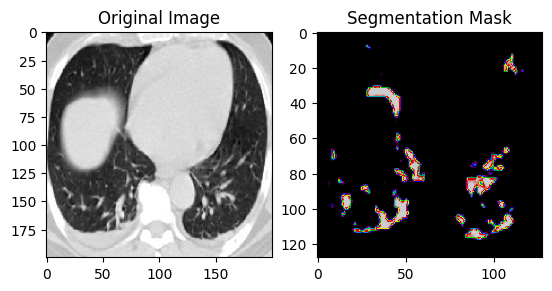

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load mô hình phát hiện COVID-19
densenet_model = load_model('/content/drive/MyDrive/Colab Notebooks/CDCNTT/DenseNet121_L1_xam.h5')


# Load mô hình UNet với compile=False
unet_model = load_model('/content/drive/MyDrive/Colab Notebooks/chuyendecntt/input/model_unet.h5', compile=False)

# Đường dẫn của hình ảnh test
path = '/content/drive/MyDrive/Colab Notebooks/CDCNTT/TEST/COVID/Covid (1125).png'

# Chuẩn bị dữ liệu cho mô hình dự đoán COVID-19
img = image.load_img(path, color_mode='grayscale', target_size=(128, 128))  # Điều chỉnh kích thước ảnh đầu vào thành (128, 128)
show_img = image.load_img(path, color_mode='grayscale', target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255

# Dự đoán COVID-19
prediction = densenet_model.predict(x)
covid_probability = prediction[0][0] * 100
non_covid_probability = prediction[0][1] * 100

if prediction[0][0] > prediction[0][1]:
    print(f'Prediction: COVID-19 (Probability: {covid_probability:.2f}%)')

    # Phân vùng ảnh COVID-19 bằng mô hình UNet
    mask = unet_model.predict(x)

    # Hiển thị kết quả phân vùng
    plt.subplot(1, 2, 1)
    plt.imshow(show_img, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask[0][:, :, 0], cmap='nipy_spectral')
    plt.title('Segmentation Mask')

    plt.show()

else:
    print(f'Prediction: Non COVID-19 (Probability: {non_covid_probability:.2f}%)')